## 1. Credit Risk Modelling

In [1]:
#importing the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, precision_recall_curve
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split

%matplotlib inline

import warnings 
warnings.filterwarnings("ignore")


In [2]:
#reading the data
data = pd.read_csv('loan_data.csv')

In [3]:
data.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,B5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
#reading the dictionary to get the target column
data_dict = pd.read_excel('Data_Dictionary.xlsx', engine='openpyxl')
data_dict.head()

,Features,Description,Target
0,addr_state,The state provided by the borrower in the loan...,False
1,annual_inc,The self-reported annual income provided by th...,False
2,annual_inc_joint,The combined self-reported annual income provi...,False
3,application_type,Indicates whether the loan is an individual ap...,False
4,collection_recovery_fee,post charge off collection fee,False


In [5]:
#target column 
data_dict[data_dict['Target']==True]

,Features,Description,Target
32,loan_status,Current status of the loan,True


In [6]:
#looking at different class labels present in target column and number of instances belonging to each label
data['loan_status'].value_counts()

Current                                                224226
Fully Paid                                             184739
Charged Off                                             42475
Late (31-120 days)                                       6900
In Grace Period                                          3146
Does not meet the credit policy. Status:Fully Paid       1988
Late (16-30 days)                                        1218
Default                                                   832
Does not meet the credit policy. Status:Charged Off       761
Name: loan_status, dtype: int64

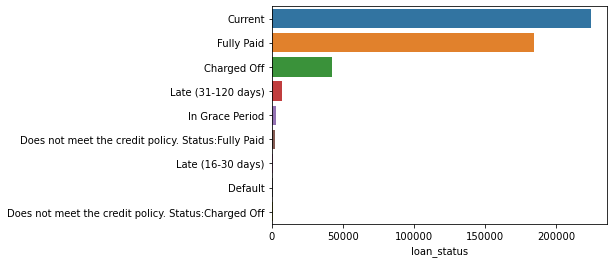

In [7]:
#plot showing number of instances belonging to each class label
ax = sns.barplot(y=data['loan_status'].value_counts().index, x=data['loan_status'].value_counts())

### Preprocessing the Target column :

- As we are focussing on Probability of deafult, it could be understood as the likelihood that a borrower will fail to pay back a debt.
- So looking at our loan_status column, classes like Charged Off, Default, Late (31-120 days), and Does not meet the credit policy. Status:Charged Off should be included in the default or '0' class and rest others should be in good or '1' class.

In [8]:
# create a new column based on the loan_status column that will be our target variable
data['good_default'] = np.where(data.loc[:, 'loan_status'].isin(['Charged Off', 'Default', 'Late (31-120 days)',
                                                                       'Does not meet the credit policy. Status:Charged Off']), 0, 1)
# Drop the original 'loan_status' column
data.drop(columns = ['loan_status'], inplace = True)

In [9]:
#getting info about null values and datatypes for all the columns
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 74 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           466285 non-null  int64  
 1   member_id                    466285 non-null  int64  
 2   loan_amnt                    466285 non-null  int64  
 3   funded_amnt                  466285 non-null  int64  
 4   funded_amnt_inv              466285 non-null  float64
 5   term                         466285 non-null  object 
 6   int_rate                     466285 non-null  float64
 7   installment                  466285 non-null  float64
 8   grade                        466285 non-null  object 
 9   sub_grade                    466285 non-null  object 
 10  emp_title                    438697 non-null  object 
 11  emp_length                   445277 non-null  object 
 12  home_ownership               466285 non-null  object 
 13 

In [10]:
#checking on, how many columns have null values and how many don't
print(data.isna().sum()[data.isna().sum()==0].count())
print(data.isna().sum()[data.isna().sum()>0].count())

34
40


<AxesSubplot:>

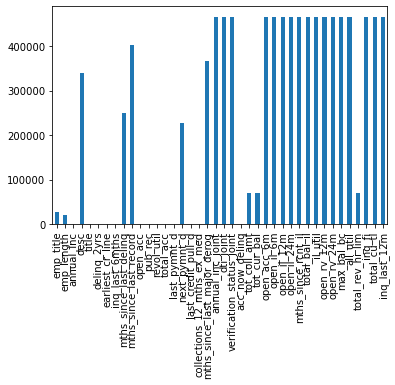

In [11]:
# As seen above 40 columns have null values, checking with plot how many null values they have
data.isna().sum()[data.isna().sum()>0].plot(kind='bar')

### Missing values 
- As we have seen in the above plot that many columns have around 60%-70% missing values.
- So, it will be waste to impute them as any technique to impute them will most likely result in inaccurate results.
- So, lets check for columns having more than 70% missing values

20


<AxesSubplot:>

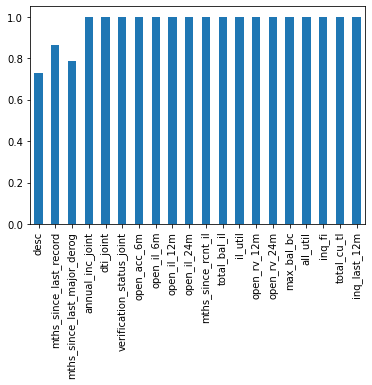

In [12]:
missing_values = data.isna().mean()
print(missing_values[missing_values>0.7].count())
missing_values[missing_values>0.7].plot(kind='bar')

In [13]:
# dropping the columns having more than 70 % missing values
column_70 = list(missing_values[missing_values>0.7].index)
print(column_70)
data.drop(column_70, axis=1, inplace=True)

['desc', 'mths_since_last_record', 'mths_since_last_major_derog', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'open_acc_6m', 'open_il_6m', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'inq_fi', 'total_cu_tl', 'inq_last_12m']


### Drop columns
- There are certain columns which will not help us in results as we are looking at Probability of Default, So columns like which are giving id info and which are like forward looking columns, dropping them here. 

In [14]:
columns_to_drop = ['id', 'member_id', 'sub_grade', 'emp_title', 'url','title', 'zip_code', 'next_pymnt_d',
                          'recoveries', 'collection_recovery_fee', 'total_rec_prncp', 'total_rec_late_fee','policy_code']
data.drop(columns_to_drop, inplace=True, axis=1)


<AxesSubplot:>

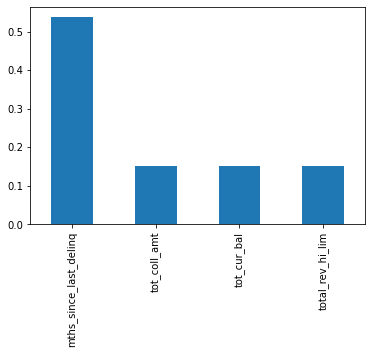

In [15]:
#checking for the missing values again
missing_values = data.isna().mean()
missing_values[missing_values>0.1].plot(kind='bar')

In [16]:
#dropping all missing values
data.dropna(inplace=True)

In [17]:
data.shape

(181686, 41)

### Correlation Check
- As we have many columns with us, there is possibility that some of them will be correlated, in that case removing them will help us in feature reduction as they all would be giving  the same info as they are related.

In [18]:
corr_matrix = data.corr()
corr_matrix

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,...,total_pymnt,total_pymnt_inv,total_rec_int,last_pymnt_amnt,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,good_default
loan_amnt,1.000000,0.999996,0.999992,0.177538,0.950538,0.337708,0.018928,0.014195,-0.012577,-0.042768,...,0.731291,0.731352,0.732478,0.275365,-0.014728,0.006445,-0.003080,0.299252,0.215081,-0.033023
funded_amnt,0.999996,1.000000,0.999995,0.177526,0.950542,0.337704,0.018923,0.014193,-0.012590,-0.042761,...,0.731298,0.731359,0.732477,0.275371,-0.014728,0.006446,-0.003080,0.299249,0.215081,-0.033004
funded_amnt_inv,0.999992,0.999995,1.000000,0.177703,0.950534,0.337729,0.018928,0.014212,-0.012527,-0.042752,...,0.731168,0.731237,0.732473,0.275324,-0.014732,0.006435,-0.003079,0.299238,0.215066,-0.033022
int_rate,0.177538,0.177526,0.177703,1.000000,0.151286,-0.041277,0.132896,0.047264,0.238915,-0.042830,...,0.155967,0.156154,0.497445,0.085896,0.014704,0.035114,0.000021,-0.065960,-0.091219,-0.169128
installment,0.950538,0.950542,0.950534,0.151286,1.000000,0.337168,0.011325,0.020783,0.015726,-0.046790,...,0.764232,0.764301,0.661083,0.279129,-0.013547,0.009233,-0.002557,0.272323,0.202502,-0.038148
annual_inc,0.337708,0.337704,0.337729,-0.041277,0.337168,1.000000,-0.221698,0.049583,0.060377,-0.061775,...,0.269612,0.269653,0.198058,0.118165,-0.004302,0.017960,0.002107,0.440722,0.220790,0.037894
dti,0.018928,0.018923,0.018928,0.132896,0.011325,-0.221698,1.000000,0.000229,-0.006620,0.006759,...,-0.038089,-0.038081,0.066179,-0.055705,-0.005131,0.012731,-0.004470,-0.048852,0.041074,-0.058060
delinq_2yrs,0.014195,0.014193,0.014212,0.047264,0.020783,0.049583,0.000229,1.000000,0.005740,-0.578305,...,-0.007942,-0.007924,0.025006,-0.017932,0.025296,0.114326,-0.003535,0.075872,-0.004426,-0.009526
inq_last_6mths,-0.012577,-0.012590,-0.012527,0.238915,0.015726,0.060377,-0.006620,0.005740,1.000000,0.012798,...,0.036208,0.036294,0.057998,0.049768,-0.002225,-0.013096,0.001772,0.051748,0.004712,-0.059494
mths_since_last_delinq,-0.042768,-0.042761,-0.042752,-0.042830,-0.046790,-0.061775,0.006759,-0.578305,0.012798,1.000000,...,-0.018173,-0.018173,-0.043853,0.006493,-0.032670,-0.137978,0.003924,-0.098704,-0.025162,0.003394


(array([ 0.5,  2.5,  4.5,  6.5,  8.5, 10.5, 12.5, 14.5, 16.5, 18.5, 20.5,
        22.5, 24.5, 26.5]),
 [Text(0, 0.5, 'loan_amnt'),
  Text(0, 2.5, 'funded_amnt_inv'),
  Text(0, 4.5, 'installment'),
  Text(0, 6.5, 'dti'),
  Text(0, 8.5, 'inq_last_6mths'),
  Text(0, 10.5, 'open_acc'),
  Text(0, 12.5, 'revol_bal'),
  Text(0, 14.5, 'total_acc'),
  Text(0, 16.5, 'out_prncp_inv'),
  Text(0, 18.5, 'total_pymnt_inv'),
  Text(0, 20.5, 'last_pymnt_amnt'),
  Text(0, 22.5, 'acc_now_delinq'),
  Text(0, 24.5, 'tot_cur_bal'),
  Text(0, 26.5, 'good_default')])

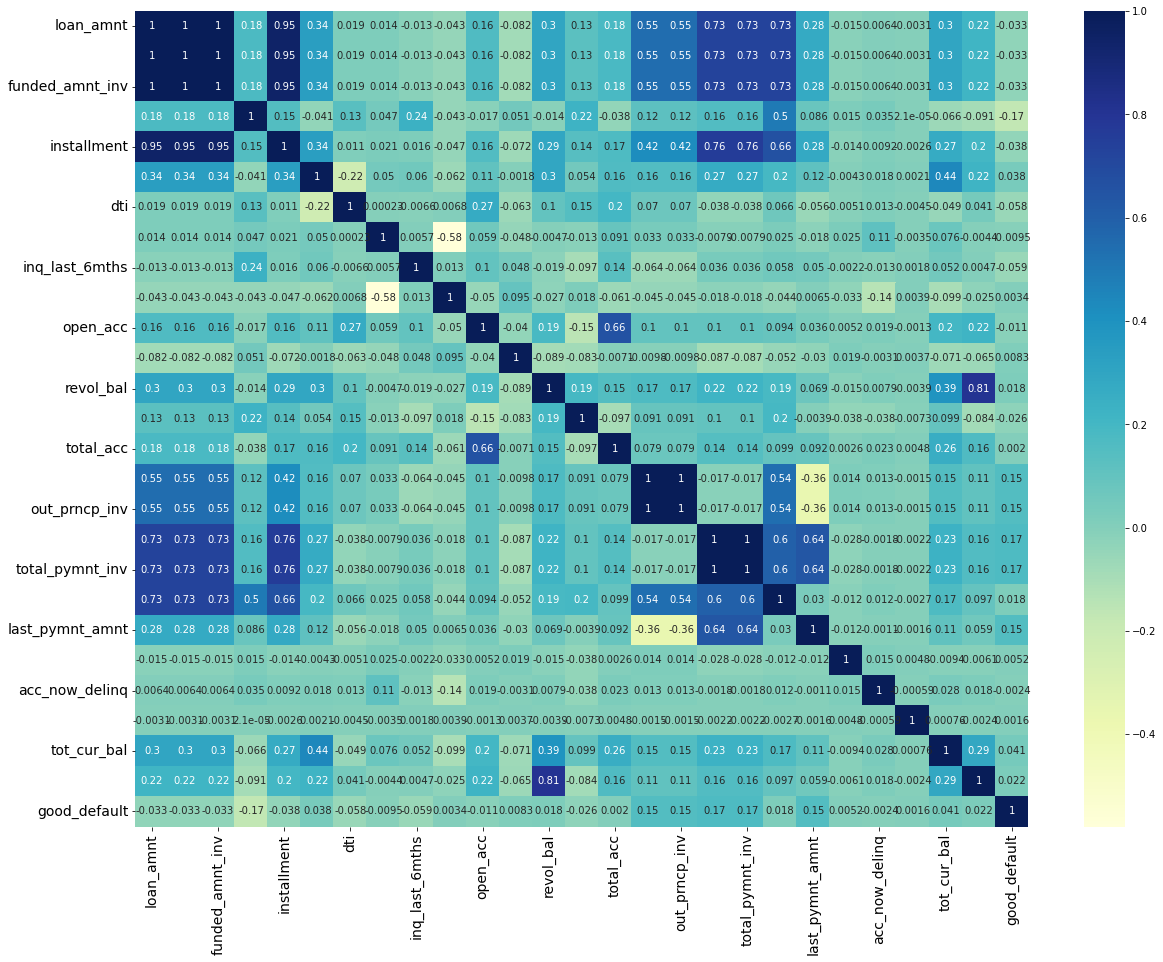

In [19]:
# correlation matrix showing correlation co-effiecients 
corr_matrix = data.corr()
heatMap=sns.heatmap(corr_matrix, annot=True,  cmap="YlGnBu", annot_kws={'size':10})
heatmap=plt.gcf()
heatmap.set_size_inches(20,15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

In [20]:
# droping multicollinear features, as seen from the plot above the features mentioned in the list below are correlated, dropping them
data.drop(columns=['loan_amnt', 'revol_bal', 'funded_amnt', 'funded_amnt_inv', 'installment',  'total_pymnt_inv',  'out_prncp_inv',  'total_acc'], inplace=True)

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5]),
 [Text(0, 0.5, 'int_rate'),
  Text(0, 1.5, 'annual_inc'),
  Text(0, 2.5, 'dti'),
  Text(0, 3.5, 'delinq_2yrs'),
  Text(0, 4.5, 'inq_last_6mths'),
  Text(0, 5.5, 'mths_since_last_delinq'),
  Text(0, 6.5, 'open_acc'),
  Text(0, 7.5, 'pub_rec'),
  Text(0, 8.5, 'revol_util'),
  Text(0, 9.5, 'out_prncp'),
  Text(0, 10.5, 'total_pymnt'),
  Text(0, 11.5, 'total_rec_int'),
  Text(0, 12.5, 'last_pymnt_amnt'),
  Text(0, 13.5, 'collections_12_mths_ex_med'),
  Text(0, 14.5, 'acc_now_delinq'),
  Text(0, 15.5, 'tot_coll_amt'),
  Text(0, 16.5, 'tot_cur_bal'),
  Text(0, 17.5, 'total_rev_hi_lim'),
  Text(0, 18.5, 'good_default')])

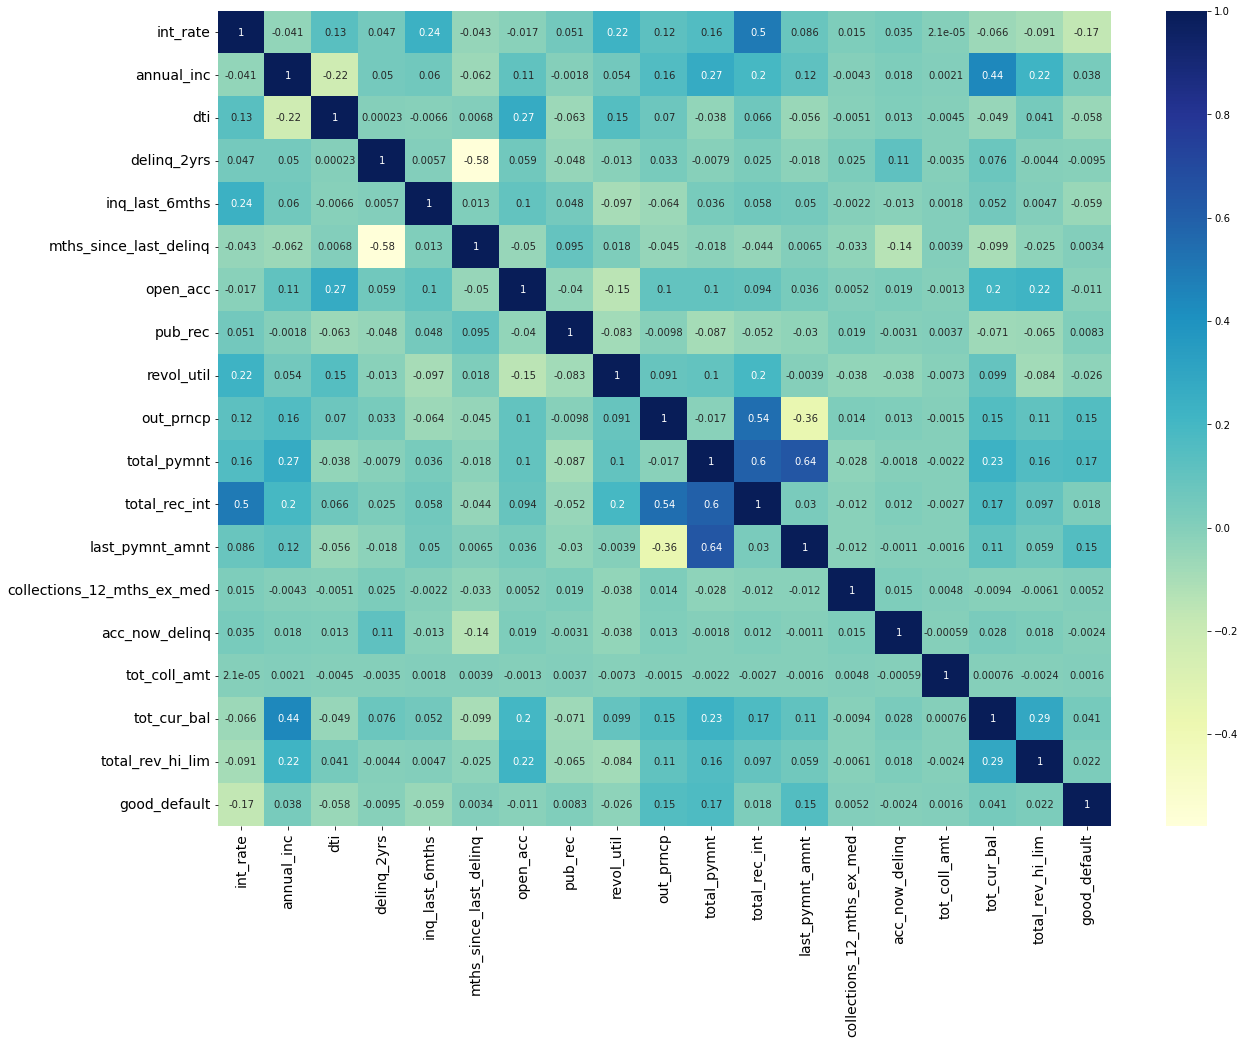

In [21]:
#checking for correlation after dropping the columns above
corr_matrix = data.corr()
heatMap=sns.heatmap(corr_matrix, annot=True,  cmap="YlGnBu", annot_kws={'size':10})
heatmap=plt.gcf()
heatmap.set_size_inches(20,15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

In [22]:
data.shape

(181686, 33)

In [23]:
##descriptive statistics
data.describe()

,int_rate,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_util,out_prncp,total_pymnt,total_rec_int,last_pymnt_amnt,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,good_default
count,181686.000000,1.816860e+05,181686.000000,181686.000000,181686.000000,181686.000000,181686.000000,181686.000000,181686.000000,181686.000000,181686.000000,181686.000000,181686.000000,181686.000000,181686.000000,1.816860e+05,1.816860e+05,1.816860e+05,181686.000000
mean,14.449868,7.886698e+04,17.389873,0.638040,0.822942,33.724167,11.756382,0.189244,56.548318,5291.496180,11215.608032,2679.857733,3146.519033,0.016418,0.009808,3.263843e+02,1.505644e+05,2.735155e+04,0.901897
std,4.252272,6.078531e+04,7.787230,1.104461,1.059299,21.716923,4.997763,0.557625,22.583195,6660.857513,7986.951463,2470.226061,5633.250884,0.149082,0.107319,2.157745e+04,1.595617e+05,4.243696e+04,0.297455
min,6.000000,4.000000e+03,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,35.690000,0.000000,0.010000,0.000000,0.000000,0.000000e+00,0.000000e+00,1.000000e+02,0.000000
25%,11.670000,5.000000e+04,11.530000,0.000000,0.000000,15.000000,8.000000,0.000000,40.300000,0.000000,5485.875000,1037.310000,321.130000,0.000000,0.000000,0.000000e+00,3.245125e+04,1.230000e+04,1.000000
50%,14.160000,6.800000e+04,16.910000,0.000000,0.000000,30.000000,11.000000,0.000000,57.400000,2637.215000,9127.115000,1925.520000,539.810000,0.000000,0.000000,0.000000e+00,9.847150e+04,2.060000e+04,1.000000
75%,17.140000,9.402825e+04,22.900000,1.000000,1.000000,49.000000,14.000000,0.000000,73.900000,8883.127500,14685.300000,3432.090000,3048.777500,0.000000,0.000000,0.000000e+00,2.255148e+05,3.400000e+04,1.000000
max,26.060000,7.500000e+06,39.990000,29.000000,7.000000,188.000000,84.000000,21.000000,892.300000,31898.770000,56087.909920,21840.000000,36170.140000,20.000000,5.000000,9.152545e+06,8.000078e+06,9.999999e+06,1.000000


In [24]:
#check datatypes of data again to check what all columns need preprocessing
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 181686 entries, 42537 to 466284
Data columns (total 33 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   term                        181686 non-null  object 
 1   int_rate                    181686 non-null  float64
 2   grade                       181686 non-null  object 
 3   emp_length                  181686 non-null  object 
 4   home_ownership              181686 non-null  object 
 5   annual_inc                  181686 non-null  float64
 6   verification_status         181686 non-null  object 
 7   issue_d                     181686 non-null  object 
 8   pymnt_plan                  181686 non-null  object 
 9   purpose                     181686 non-null  object 
 10  addr_state                  181686 non-null  object 
 11  dti                         181686 non-null  float64
 12  delinq_2yrs                 181686 non-null  float64
 13  earliest_c

In [25]:
#as seen above 'emp_length' columns needs to be converted into numeric, checking the unique values in it
data['emp_length'].unique()

array(['10+ years', '2 years', '4 years', '7 years', '6 years', '5 years',
       '8 years', '3 years', '1 year', '< 1 year', '9 years'],
      dtype=object)

In [26]:
## steps to be performed as per each unique values
# data['emp_length'] = data['emp_length'].str.replace('\+ years', '')
# data['emp_length'] = data['emp_length'].str.replace('< 1 year', str(0))
# data['emp_length'] = data['emp_length'].str.replace(' years', '')
# data['emp_length'] = data['emp_length'].str.replace(' year', '')
# data['emp_length'] = pd.to_numeric(data['emp_length'])
# data['emp_length'].fillna(value = 0, inplace = True)

In [27]:
# data['emp_length'].unique()

In [28]:
# converting emp_length to numerical column and assign nan values to zero (basically took all the steps tried in above cell)

def emp_length_convert(df, column):
    df[column] = df[column].str.replace('\+ years', '')
    df[column] = df[column].str.replace('< 1 year', str(0))
    df[column] = df[column].str.replace(' years', '')
    df[column] = df[column].str.replace(' year', '')
    df[column] = pd.to_numeric(df[column])
    df[column].fillna(value = 0, inplace = True)
    

emp_length_convert(data, 'emp_length')

data['emp_length'].unique()


array([10,  2,  4,  7,  6,  5,  8,  3,  1,  0,  9], dtype=int64)

In [29]:
data['emp_length'].dtype

dtype('int64')

In [30]:
# converting term column to numeric data type

def term_numeric(df, column):
    df[column] = pd.to_numeric(df[column].str.replace(' months', ''))
    
term_numeric(data, 'term')

    

In [31]:
data['term'].dtype

dtype('int64')

In [32]:
# preprocessing date columns 

def date_columns(df, column):
    # store current month
    today_date = pd.to_datetime('2022-04-30')
    # convert to datetime format
    df[column] = pd.to_datetime(df[column], format = "%b-%y")
    # calculate the difference in months and add to a new column
    df['mths_since_' + column] = round(pd.to_numeric((today_date - df[column]) / np.timedelta64(1, 'M')))
    # make any resulting -ve values to be equal to the max date
    df['mths_since_' + column] = df['mths_since_' + column].apply(lambda x: df['mths_since_' + column].max() if x < 0 else x)
    # drop the original date column
    df.drop(columns = [column], inplace = True)
    

date_columns(data, 'issue_d')
date_columns(data, 'last_pymnt_d')
date_columns(data, 'last_credit_pull_d')
date_columns(data, 'earliest_cr_line')

In [33]:
# checking for missing values again 
missing_values = data.isnull().sum()
missing_values[missing_values>0]/len(data)

Series([], dtype: float64)

In [34]:
# seperating categorical features from numerical
categorical_features = data.select_dtypes(exclude='number')
numerical_features = data.select_dtypes(exclude='object')

In [35]:
#checking categorical features data types
categorical_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 181686 entries, 42537 to 466284
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   grade                181686 non-null  object
 1   home_ownership       181686 non-null  object
 2   verification_status  181686 non-null  object
 3   pymnt_plan           181686 non-null  object
 4   purpose              181686 non-null  object
 5   addr_state           181686 non-null  object
 6   initial_list_status  181686 non-null  object
 7   application_type     181686 non-null  object
dtypes: object(8)
memory usage: 12.5+ MB


In [36]:
#checking numerical features data types
numerical_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 181686 entries, 42537 to 466284
Data columns (total 25 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   term                           181686 non-null  int64  
 1   int_rate                       181686 non-null  float64
 2   emp_length                     181686 non-null  int64  
 3   annual_inc                     181686 non-null  float64
 4   dti                            181686 non-null  float64
 5   delinq_2yrs                    181686 non-null  float64
 6   inq_last_6mths                 181686 non-null  float64
 7   mths_since_last_delinq         181686 non-null  float64
 8   open_acc                       181686 non-null  float64
 9   pub_rec                        181686 non-null  float64
 10  revol_util                     181686 non-null  float64
 11  out_prncp                      181686 non-null  float64
 12  total_pymnt               

In [37]:
data.head()

,term,int_rate,grade,emp_length,home_ownership,annual_inc,verification_status,pymnt_plan,purpose,addr_state,...,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,good_default,mths_since_issue_d,mths_since_last_pymnt_d,mths_since_last_credit_pull_d,mths_since_earliest_cr_line
42537,36,6.62,A,10,MORTGAGE,105000.0,Not Verified,n,debt_consolidation,CT,...,INDIVIDUAL,0.0,0.0,267646.0,61100.0,1,101.0,76.0,76.0,338.0
42538,36,13.53,B,10,RENT,40000.0,Source Verified,n,debt_consolidation,NM,...,INDIVIDUAL,0.0,15386.0,13605.0,8100.0,1,101.0,80.0,76.0,283.0
42539,36,8.90,A,2,MORTGAGE,63000.0,Not Verified,n,debt_consolidation,FL,...,INDIVIDUAL,0.0,1514.0,272492.0,15400.0,1,101.0,76.0,76.0,290.0
42541,36,12.85,B,4,RENT,88000.0,Not Verified,n,debt_consolidation,NC,...,INDIVIDUAL,0.0,0.0,17672.0,4500.0,1,101.0,76.0,76.0,407.0
42543,36,9.67,B,7,MORTGAGE,102000.0,Not Verified,n,debt_consolidation,MA,...,INDIVIDUAL,0.0,0.0,39143.0,22300.0,1,101.0,76.0,76.0,391.0


In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 181686 entries, 42537 to 466284
Data columns (total 33 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   term                           181686 non-null  int64  
 1   int_rate                       181686 non-null  float64
 2   grade                          181686 non-null  object 
 3   emp_length                     181686 non-null  int64  
 4   home_ownership                 181686 non-null  object 
 5   annual_inc                     181686 non-null  float64
 6   verification_status            181686 non-null  object 
 7   pymnt_plan                     181686 non-null  object 
 8   purpose                        181686 non-null  object 
 9   addr_state                     181686 non-null  object 
 10  dti                            181686 non-null  float64
 11  delinq_2yrs                    181686 non-null  float64
 12  inq_last_6mths            

In [39]:
preprocess_data = data.copy()

In [40]:
#checking for any missing values
missing = preprocess_data.isnull().sum()
missing[missing>0]

Series([], dtype: int64)

In [41]:
#function to calculate weight of evidence and information value 
# reference : https://www.analyticsvidhya.com/blog/2021/06/understand-weight-of-evidence-and-information-value/
#https://medium.com/mlearning-ai/weight-of-evidence-woe-and-information-value-iv-how-to-use-it-in-eda-and-model-building-3b3b98efe0e8

def iv_woe(data, target, bins=10, show_woe=False):
    
    #Empty Dataframe
    newDF,woeDF = pd.DataFrame(), pd.DataFrame()
    
    #Extract Column Names
    cols = data.columns
    
    #Run WOE and IV on all the independent variables
    for ivars in cols[~cols.isin([target])]:
        if (data[ivars].dtype.kind in 'bifc') and (len(np.unique(data[ivars]))>10):
            binned_x = pd.qcut(data[ivars], bins,  duplicates='drop')
            d0 = pd.DataFrame({'x': binned_x, 'y': data[target]})
        else:
            d0 = pd.DataFrame({'x': data[ivars], 'y': data[target]})
        d = d0.groupby("x", as_index=False).agg({"y": ["count", "sum"]})
        d.columns = ['Cutoff', 'N', 'Events']
        d['% of Events'] = np.maximum(d['Events'], 0.5) / d['Events'].sum()
        d['Non-Events'] = d['N'] - d['Events']
        d['% of Non-Events'] = np.maximum(d['Non-Events'], 0.5) / d['Non-Events'].sum()
        d['WoE'] = np.log(d['% of Events']/d['% of Non-Events'])
        d['IV'] = d['WoE'] * (d['% of Events'] - d['% of Non-Events'])
        d.insert(loc=0, column='Variable', value=ivars)
        print("Information value of " + ivars + " is " + str(round(d['IV'].sum(),6)))
        temp =pd.DataFrame({"Variable" : [ivars], "IV" : [d['IV'].sum()]}, columns = ["Variable", "IV"])
        newDF=pd.concat([newDF,temp], axis=0)
        woeDF=pd.concat([woeDF,d], axis=0)

        #Show WOE Table
        if show_woe == True:
            print(d)
    return newDF, woeDF
iv, woe = iv_woe(preprocess_data, target='good_default', bins=20)

Information value of term is 0.035478
Information value of int_rate is 0.347724
Information value of grade is 0.281145
Information value of emp_length is 0.007174
Information value of home_ownership is 0.017952
Information value of annual_inc is 0.037998
Information value of verification_status is 0.033377
Information value of pymnt_plan is 0.000309
Information value of purpose is 0.028333
Information value of addr_state is 0.010291
Information value of dti is 0.041026
Information value of delinq_2yrs is 0.001039
Information value of inq_last_6mths is 0.040454
Information value of mths_since_last_delinq is 0.002487
Information value of open_acc is 0.004499
Information value of pub_rec is 0.000504
Information value of revol_util is 0.008858
Information value of initial_list_status is 0.011513
Information value of out_prncp is 0.703375
Information value of total_pymnt is 0.515794
Information value of total_rec_int is 0.011108
Information value of last_pymnt_amnt is 1.491828
Information v

In [42]:
print(iv)

                        Variable        IV
0                           term  0.035478
0                       int_rate  0.347724
0                          grade  0.281145
0                     emp_length  0.007174
0                 home_ownership  0.017952
0                     annual_inc  0.037998
0            verification_status  0.033377
0                     pymnt_plan  0.000309
0                        purpose  0.028333
0                     addr_state  0.010291
0                            dti  0.041026
0                    delinq_2yrs  0.001039
0                 inq_last_6mths  0.040454
0         mths_since_last_delinq  0.002487
0                       open_acc  0.004499
0                        pub_rec  0.000504
0                     revol_util  0.008858
0            initial_list_status  0.011513
0                      out_prncp  0.703375
0                    total_pymnt  0.515794
0                  total_rec_int  0.011108
0                last_pymnt_amnt  1.491828
0     colle

In [43]:
#droping columns with low information value
preprocess_data.drop(columns=[ 'pymnt_plan', 'last_pymnt_amnt', 'revol_util', 'delinq_2yrs', 'mths_since_last_delinq', 'open_acc', 'pub_rec',  'collections_12_mths_ex_med', 'acc_now_delinq',
                              'tot_coll_amt', 'mths_since_last_pymnt_d', 'emp_length', 'application_type'], axis=1, inplace=True)

In [44]:
preprocess_data.shape

(181686, 20)

In [45]:
# creating dummy variables for categorical columns
data_dummies1 = [pd.get_dummies(preprocess_data['grade'], prefix='grade', prefix_sep=':',drop_first=True),
               pd.get_dummies(preprocess_data['home_ownership'], prefix='home_ownership', prefix_sep=':',drop_first=True),
               pd.get_dummies(preprocess_data['verification_status'], prefix='verification_status', prefix_sep=':',drop_first=True),
                pd.get_dummies(preprocess_data['purpose'], prefix='purpose', prefix_sep=':',drop_first=True),
                pd.get_dummies(preprocess_data['addr_state'], prefix='addr_state', prefix_sep=':',drop_first=True),
                pd.get_dummies(preprocess_data['initial_list_status'], prefix='initial_list_status', prefix_sep=':',drop_first=True)                
               ]


In [46]:
type(data_dummies1)

list

In [47]:
# turn  data_dummies into dataframe
categorical_dummies = pd.concat(data_dummies1, axis=1)

In [48]:
categorical_dummies.head()

,grade:B,grade:C,grade:D,grade:E,grade:F,grade:G,home_ownership:MORTGAGE,home_ownership:NONE,home_ownership:OTHER,home_ownership:OWN,...,addr_state:TN,addr_state:TX,addr_state:UT,addr_state:VA,addr_state:VT,addr_state:WA,addr_state:WI,addr_state:WV,addr_state:WY,initial_list_status:w
42537,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
42538,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
42539,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
42541,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
42543,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [49]:
# concatinating preprocess_data with categorical_dummies
preprocess_data = pd.concat([preprocess_data, categorical_dummies], axis=1)

In [50]:
preprocess_data.shape

(181686, 92)

In [51]:
preprocess_data.columns

Index(['term', 'int_rate', 'grade', 'home_ownership', 'annual_inc',
       'verification_status', 'purpose', 'addr_state', 'dti', 'inq_last_6mths',
       'initial_list_status', 'out_prncp', 'total_pymnt', 'total_rec_int',
       'tot_cur_bal', 'total_rev_hi_lim', 'good_default', 'mths_since_issue_d',
       'mths_since_last_credit_pull_d', 'mths_since_earliest_cr_line',
       'grade:B', 'grade:C', 'grade:D', 'grade:E', 'grade:F', 'grade:G',
       'home_ownership:MORTGAGE', 'home_ownership:NONE',
       'home_ownership:OTHER', 'home_ownership:OWN', 'home_ownership:RENT',
       'verification_status:Source Verified', 'verification_status:Verified',
       'purpose:credit_card', 'purpose:debt_consolidation',
       'purpose:home_improvement', 'purpose:house', 'purpose:major_purchase',
       'purpose:medical', 'purpose:moving', 'purpose:other',
       'purpose:renewable_energy', 'purpose:small_business',
       'purpose:vacation', 'purpose:wedding', 'addr_state:AL', 'addr_state:AR',
  

In [52]:
#droppig columns as have already been converted to dummmy
preprocess_data.drop(['grade','home_ownership','verification_status','purpose','addr_state','initial_list_status'],axis=1,inplace=True)

In [53]:
preprocess_data.shape

(181686, 86)

<AxesSubplot:>

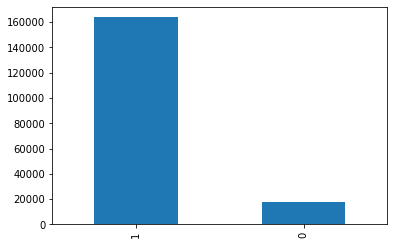

In [54]:
#checking  to see if class labels are balanced
X= preprocess_data.drop(columns='good_default', axis=1)
y = preprocess_data['good_default']
y.value_counts().plot(kind='bar')

In [55]:
#spliting data into train and test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [56]:
#dealing with imbalance data with oversampling
os = RandomOverSampler()
X_train_o, y_train_o = os.fit_resample(X_train, y_train)
y_train_series = pd.Series(y_train_o)

In [57]:
# value counts before oversampling
y_train.value_counts()

1    131089
0     14259
Name: good_default, dtype: int64

In [58]:
#check value counts after oversampling
y_train_series.value_counts()

1    131089
0    131089
Name: good_default, dtype: int64

In [59]:
#building model
model = LogisticRegression()
model.fit(X_train_o, y_train_o)

LogisticRegression()

In [60]:
#predicting
y_preds = model.predict(X_test)

In [61]:
#classification report 
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.28      0.80      0.42      3565
           1       0.97      0.78      0.87     32773

    accuracy                           0.78     36338
   macro avg       0.63      0.79      0.64     36338
weighted avg       0.90      0.78      0.82     36338



In [62]:
#Area under receiver operating charateristic curve
AUROC = roc_auc_score(y_test, y_preds)
AUROC

0.7886200708524604

### Model Performance
- As the data was imbalanced, so we can't go with accuracy on this, so if we see recall in the classification report which tells us that our model has been trained perfectly after oversampling.
- Second I am cecking AUROC score, basically an AUROC score between 0.7 to 0.8 is considered to be as acceptable model.

- Hence the model is "good"

In [64]:
# Trying hyperparameter tuning
from sklearn.model_selection import GridSearchCV
parameters = {'penalty':('l1', 'l2', 'elasticnet'), 'C':[0.01, 0.1, 1, 10]}
tuned_model = LogisticRegression()
clf = GridSearchCV(tuned_model, parameters)
clf.fit(X_train_o, y_train_o)

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1, 10],
                         'penalty': ('l1', 'l2', 'elasticnet')})

In [65]:
#checking the best paramteres
print(clf.best_params_)

{'C': 0.1, 'penalty': 'l2'}


In [66]:
#predicting
y_preds = clf.predict(X_test)

In [67]:
#classification report
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.27      0.80      0.40      3565
           1       0.97      0.76      0.85     32773

    accuracy                           0.77     36338
   macro avg       0.62      0.78      0.63     36338
weighted avg       0.90      0.77      0.81     36338



In [68]:
#Area under receiver operating charateristic cure
AUROC = roc_auc_score(y_test, y_preds)
AUROC

0.7826122390883029

### Model Performance after tuning :
- As we have printed the best parameters we can see that, the parameters that came out as best are the default parameters, so same comments on performance.

### Predicting the Probabilities

In [69]:
y_hat_test_proba = model.predict_proba(X_test)
y_hat_test_proba = y_hat_test_proba[:][: , 1]
y_test_temp = y_test.copy()
y_test_temp.reset_index(drop = True, inplace = True)
y_test_proba = pd.concat([y_test_temp, pd.DataFrame(y_hat_test_proba), pd.DataFrame(y_preds)], axis = 1)
y_test_proba.columns = ['y_test_class_actual', 'y_hat_test_proba', 'y_hat_test']
y_test_proba.index = X_test.index
y_test_proba.head()

,y_test_class_actual,y_hat_test_proba,y_hat_test
182039,1,0.859548,1
356109,1,0.363051,0
459061,1,0.742764,1
277803,1,0.575668,0
146998,1,0.667660,1


### Predicting the probabilities for default class

In [70]:
# calcualting ks statistic
actual_predicted_probs_df = y_test_proba.sort_values('y_hat_test_proba')

In [71]:
actual_predicted_probs_df.head()

,y_test_class_actual,y_hat_test_proba,y_hat_test
451987,1,2.512364e-12,0
180080,1,3.041777e-10,0
140978,0,2.249602e-04,0
130472,0,3.560203e-04,0
197707,0,4.864805e-04,0


### Predicting the Probabilties for good class

In [72]:
actual_predicted_probs_df.tail()

,y_test_class_actual,y_hat_test_proba,y_hat_test
306907,1,0.999935,1
301518,1,0.999947,1
55158,1,0.999948,1
460595,1,0.999954,1
232223,1,0.999955,1


<AxesSubplot:title={'center':'Feature Importance'}>

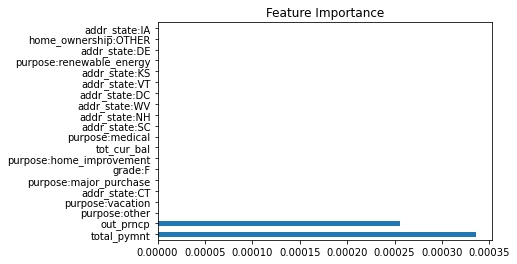

In [73]:
# Looking at the feature importance to know which features model has focussed on
feat_importances = pd.Series(model.coef_[0], index=X_test.columns)
feat_importances.nlargest(20).plot(kind='barh',title = 'Feature Importance')

In [74]:
# saving model 
import pickle
filename = 'credit_risk_model.sav'
pickle.dump(model, open(filename, 'wb'))

## 2. Credit scores to borrowers

- Generally Credit Score is calculated as a 3-digit number that ranges from 300-900 with various factors taken into consideration but as generalization purpose here, we might consider probability as credit score....because Probability gives the chances of good and bad, which means higher the probability, Higher the chances of return, hence higher the credit score.

In [78]:
actual_predicted_probs_df.tail(1)

,y_test_class_actual,y_hat_test_proba,y_hat_test
232223,1,0.999955,1


- As the probability score is 0.99, we could say that credit score is nearby 99 as (0.99*100).
- reference : https://www.bankbazaar.com/cic/how-credit-score-is-calculated.html

#### Suggestions:
- Advice from domain expert might help us get the more accurate score.